In [1]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

engine = create_engine('sqlite:///db.sqlite')
connection = engine.connect()

In [56]:
request = "SELECT * FROM LostItem"

lost_item_df = pd.read_sql(request, connection, index_col="date")

In [57]:
lost_item_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22200 entries, 2016-12-31T17:49:05+00:00 to 2022-01-01T06:57:57+00:00
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                22200 non-null  int64 
 1   type_objet        22200 non-null  object
 2   date_restitution  7926 non-null   object
dtypes: int64(1), object(2)
memory usage: 693.8+ KB


In [58]:
# Convert index to datetime and temperature to float
lost_item_df.index = pd.to_datetime(lost_item_df.index,utc=True)

In [59]:
# GROUP BY DAY AND COUNT
lost_item_df_by_day = lost_item_df.groupby(lost_item_df.index.date).count()
lost_item_df_by_day = lost_item_df_by_day[["id"]].rename(columns={"id": "nb_lost_item"})
lost_item_df_by_day.index = pd.to_datetime(lost_item_df_by_day.index)

<AxesSubplot: >

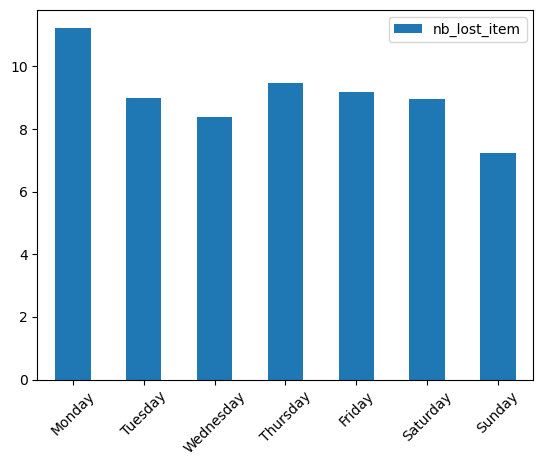

In [60]:
# GROUP BY DAY WEEK
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
lost_item_df_by_day_name = lost_item_df_by_day.groupby(lost_item_df_by_day.index.day_name()).mean()
lost_item_df_by_day_name.reindex(days).plot(kind='bar', rot=45)

<AxesSubplot: >

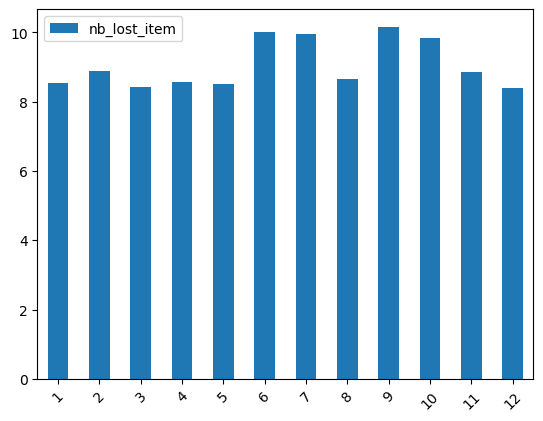

In [61]:
# GROUP BY MONTH
lost_item_df_by_month = lost_item_df_by_day.groupby(lost_item_df_by_day.index.month).mean()
lost_item_df_by_month.plot(kind='bar', rot=45)

# Evolution de la série temporelle

## Représentation

<AxesSubplot: >

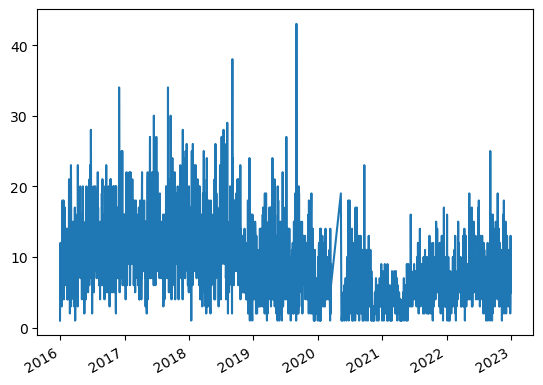

In [76]:
lost_item_df_by_day["nb_lost_item"].plot()

## Par semaine

On ne voit pas grand chose sur un si longue période (on cherche un saisonalité)

<AxesSubplot: >

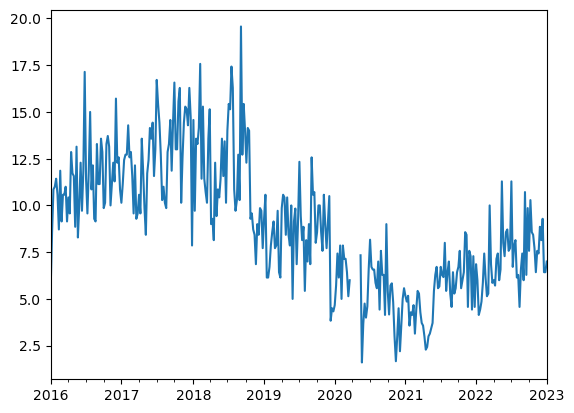

In [80]:
lost_item_df_by_day["nb_lost_item"].resample("W").mean().plot()

,nb_lost_item
2022-12-04,"AxesSubplot(0.125,0.11;0.775x0.77)"
2022-12-11,"AxesSubplot(0.125,0.11;0.775x0.77)"
2022-12-18,"AxesSubplot(0.125,0.11;0.775x0.77)"
2022-12-25,"AxesSubplot(0.125,0.11;0.775x0.77)"
2023-01-01,"AxesSubplot(0.125,0.11;0.775x0.77)"


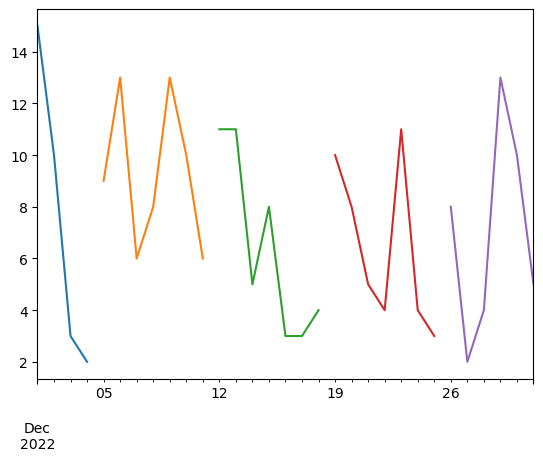

In [86]:
lost_item_df_by_day.loc[ "12-01-2022": "12-31-2022"   , ["nb_lost_item"]].resample("W").plot()

## analyse par mois

### resample

<AxesSubplot: >

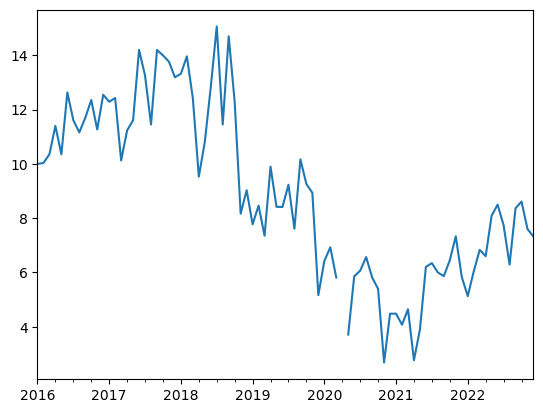

In [78]:
lost_item_df_by_day["nb_lost_item"].resample("M").mean().plot()

<AxesSubplot: >

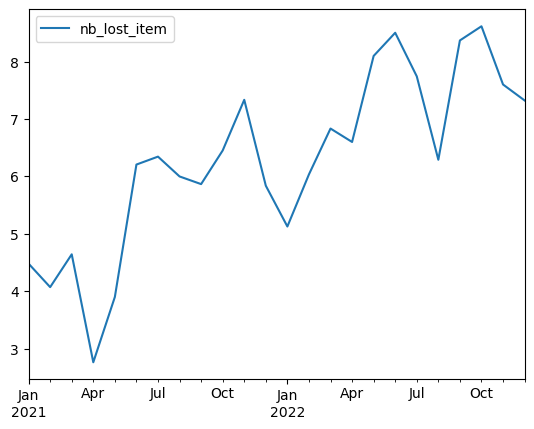

In [88]:
lost_item_df_by_day.loc[ "01-01-2021": "12-31-2022", ["nb_lost_item"]].resample("M").mean().plot()

### Analyse de toutes les années

In [101]:
import numpy as np
import matplotlib as mpl

df = lost_item_df_by_day
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.month for d in df.index]
years = df['year'].unique()

In [103]:
df

,nb_lost_item,year,month
2016-01-01,1,2016,1
2016-01-02,8,2016,1
2016-01-03,8,2016,1
2016-01-04,12,2016,1
2016-01-05,4,2016,1
...,...,...,...
2022-12-27,2,2022,12
2022-12-28,4,2022,12
2022-12-29,13,2022,12
2022-12-30,10,2022,12


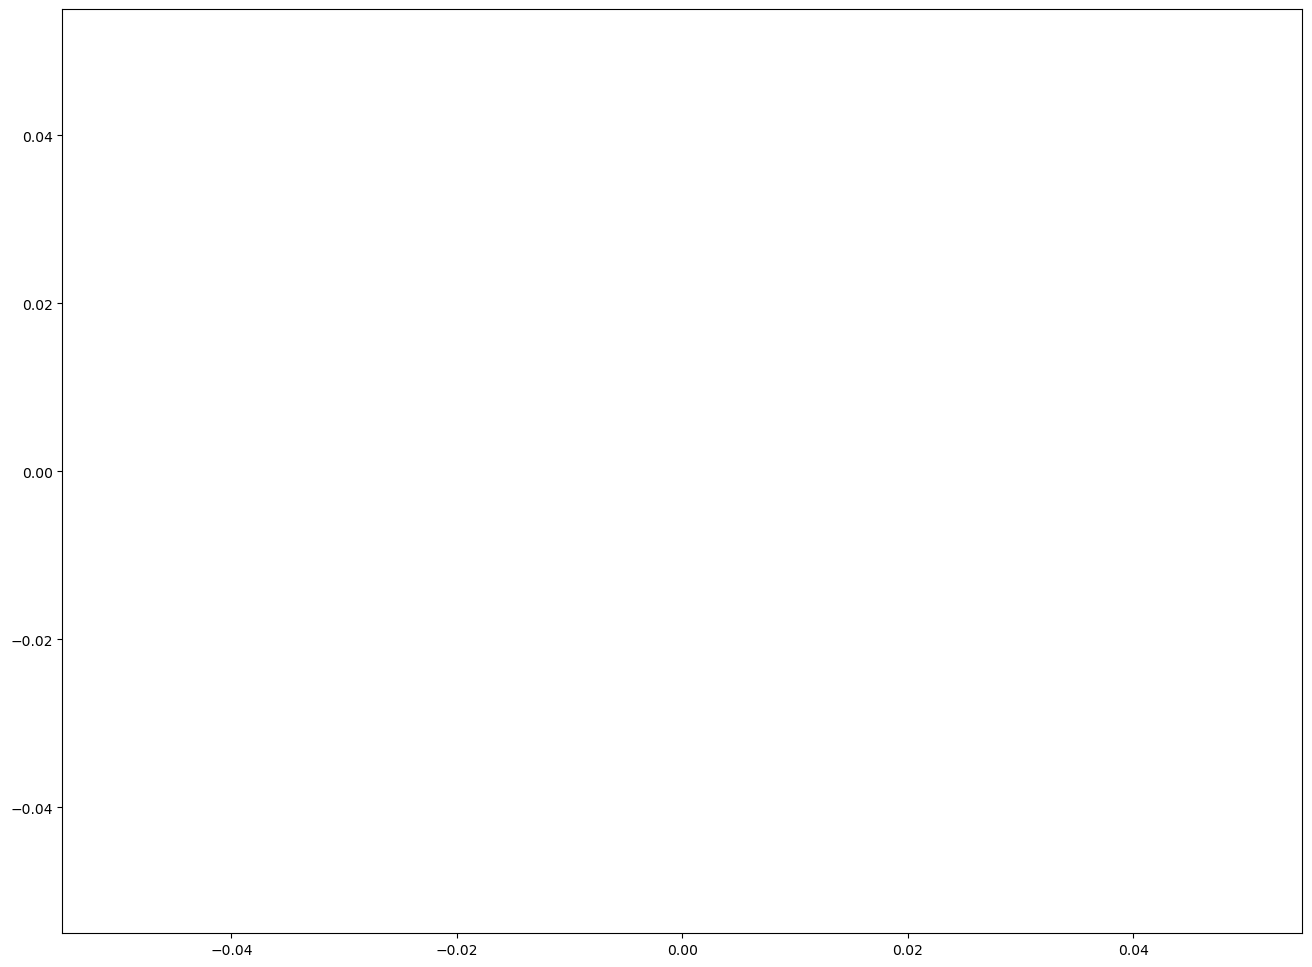

In [104]:
# Draw Plot
plt.figure(figsize=(16,12))
for y in enumerate(years):        
    plt.plot('month', 'nb_lost_item', data=df.loc[df.year==y, :], label=y)
    # plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'nb_lost_item'][-1:].values[0], y, fontsize=12, color=mycolors[i])


# Par annee

## Moyenne mobile

<AxesSubplot: >

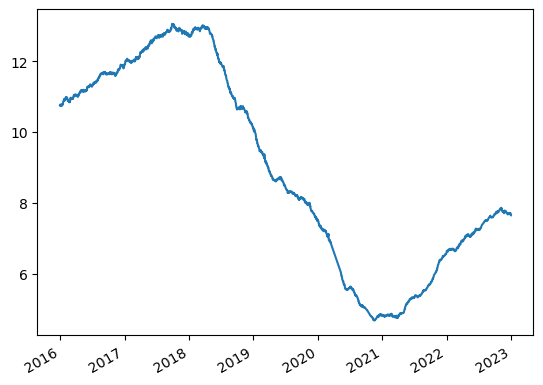

In [73]:
lost_item_df_by_day["nb_lost_item"].rolling(window="365D",center=True, win_type=None).mean().plot()

<AxesSubplot: >

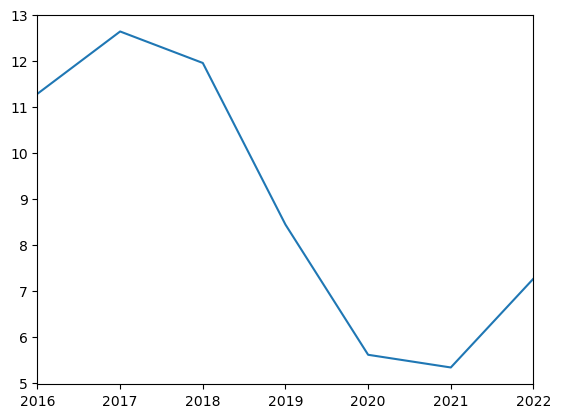

In [89]:
lost_item_df_by_day["nb_lost_item"].resample("Y").mean().plot()

# Représentation des moyenne

In [105]:
# Import Data
df = lost_item_df_by_day

# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.month for d in df.index]
years = df['year'].unique()


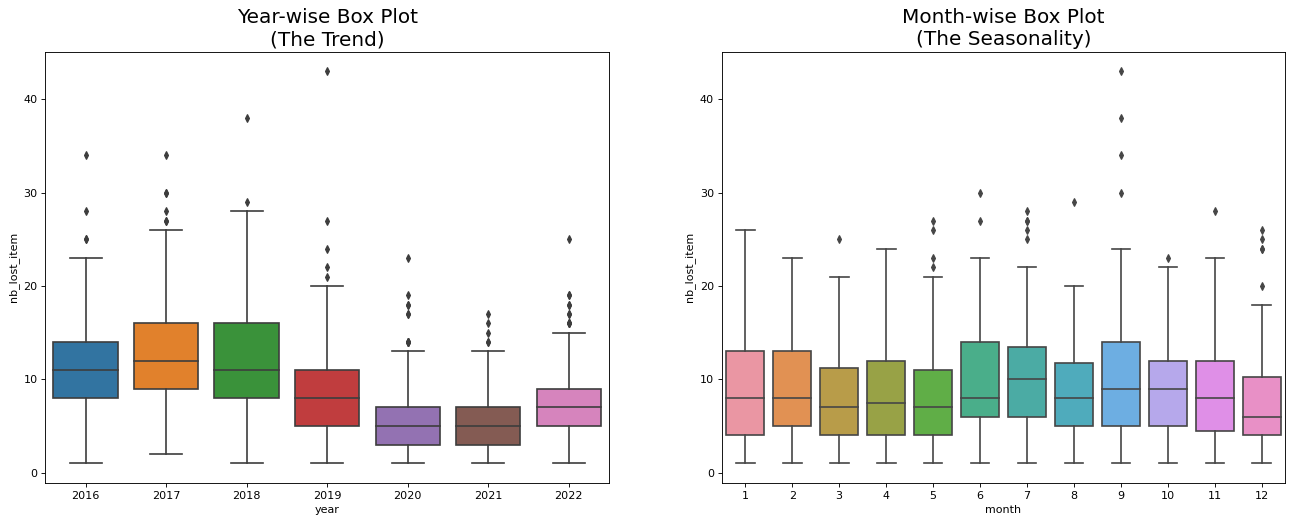

In [108]:
# Draw Plot
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='nb_lost_item', data=df, ax=axes[0])
sns.boxplot(x='month', y='nb_lost_item', data=df.loc[~df.year.isin([2016, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# Réponses aux questions

- A partir de cette première analyse, déterminez la time-series sur laquelle nous allons travailler.
  - Le covid a beaucoup bouleverser les choses, il faudrait l'exclure de l'analyse au moins pour l'approche statistiques où on ne peut pas spécifier cette particularité. 
    - Pour l'approche statistique on peut commencer en janvier 2021 pour prédire la reprise post COVID.
    - Pour l'approche ML on essayera différentes hypothèses
- Est ce que la time-série est stationnaire?
  - Non voir plus loin
- Est ce que la time-série présente une tendance?
  - A partir de janvier 2021, tendance croissance
- Est ce que la time-série présente une saisonnalité?
  - Il y a au moins une saisonnalité hebdomadaire, pour la mensuel c'est plus difficile à identifier.
- Est ce que la time série voit sa variance varier?
  - Il semble qu'elle s'acroit avec la tendance, est ce que supprimer la tendance peut la réduire?
- Bonus: combien faudrait-il de différentiation pour la rendre stationnaire?
  - Réponse Graphique: la série semble linéaire donc a priori une seule mais il faudrait réaliser la différenciation et évaluer la résultante
- Décomposez la time- série en fonction de ses 4 éléments. Considérez que c'est une time-series additive.
​

In [110]:
# Import Data
df = lost_item_df_by_day.loc["01-01-2021" :]

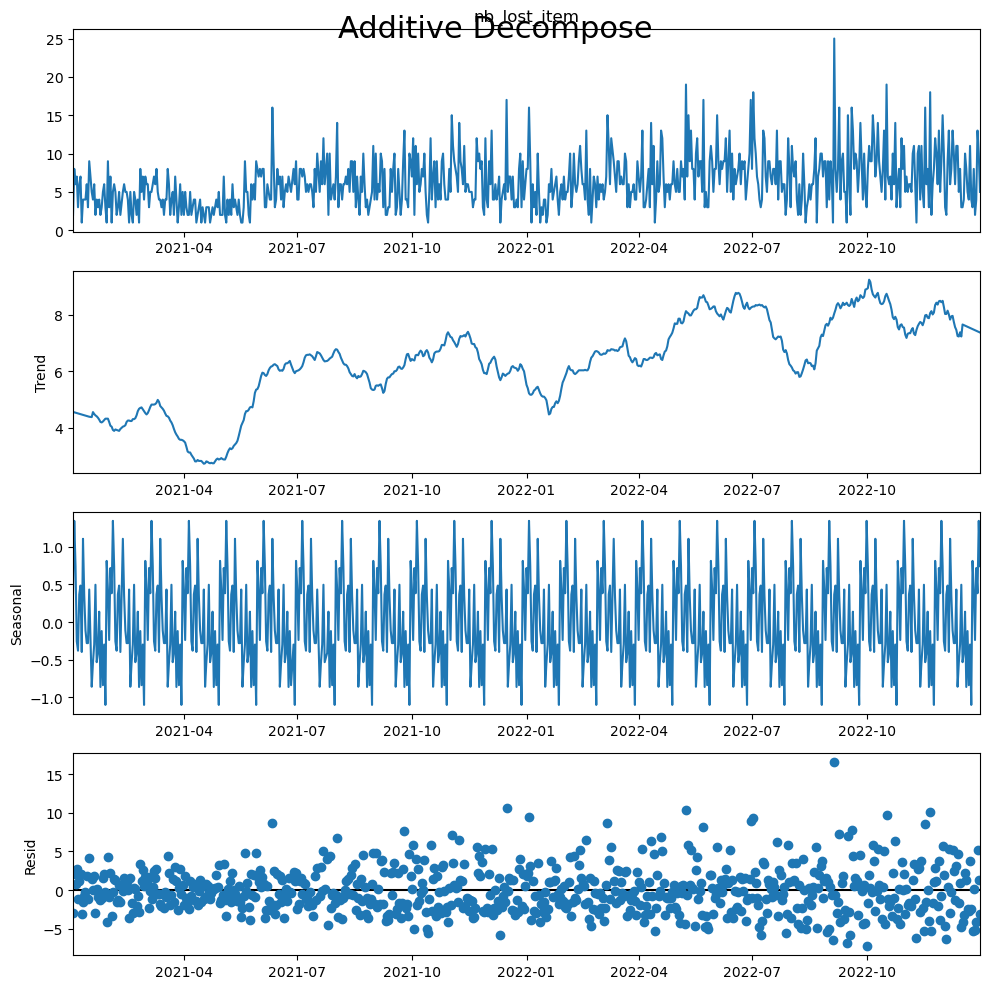

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df['nb_lost_item'], model='additive',period=30, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()